# Import Dependencies

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import cv2
import os
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# Load Dataset

In [21]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

DATADIR = "/content/drive/My Drive/2024-Tugas PKAC/Covid-19 Classification using CNN/COVID-19"

CATEGORIES = ["Negatif", "Positif"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


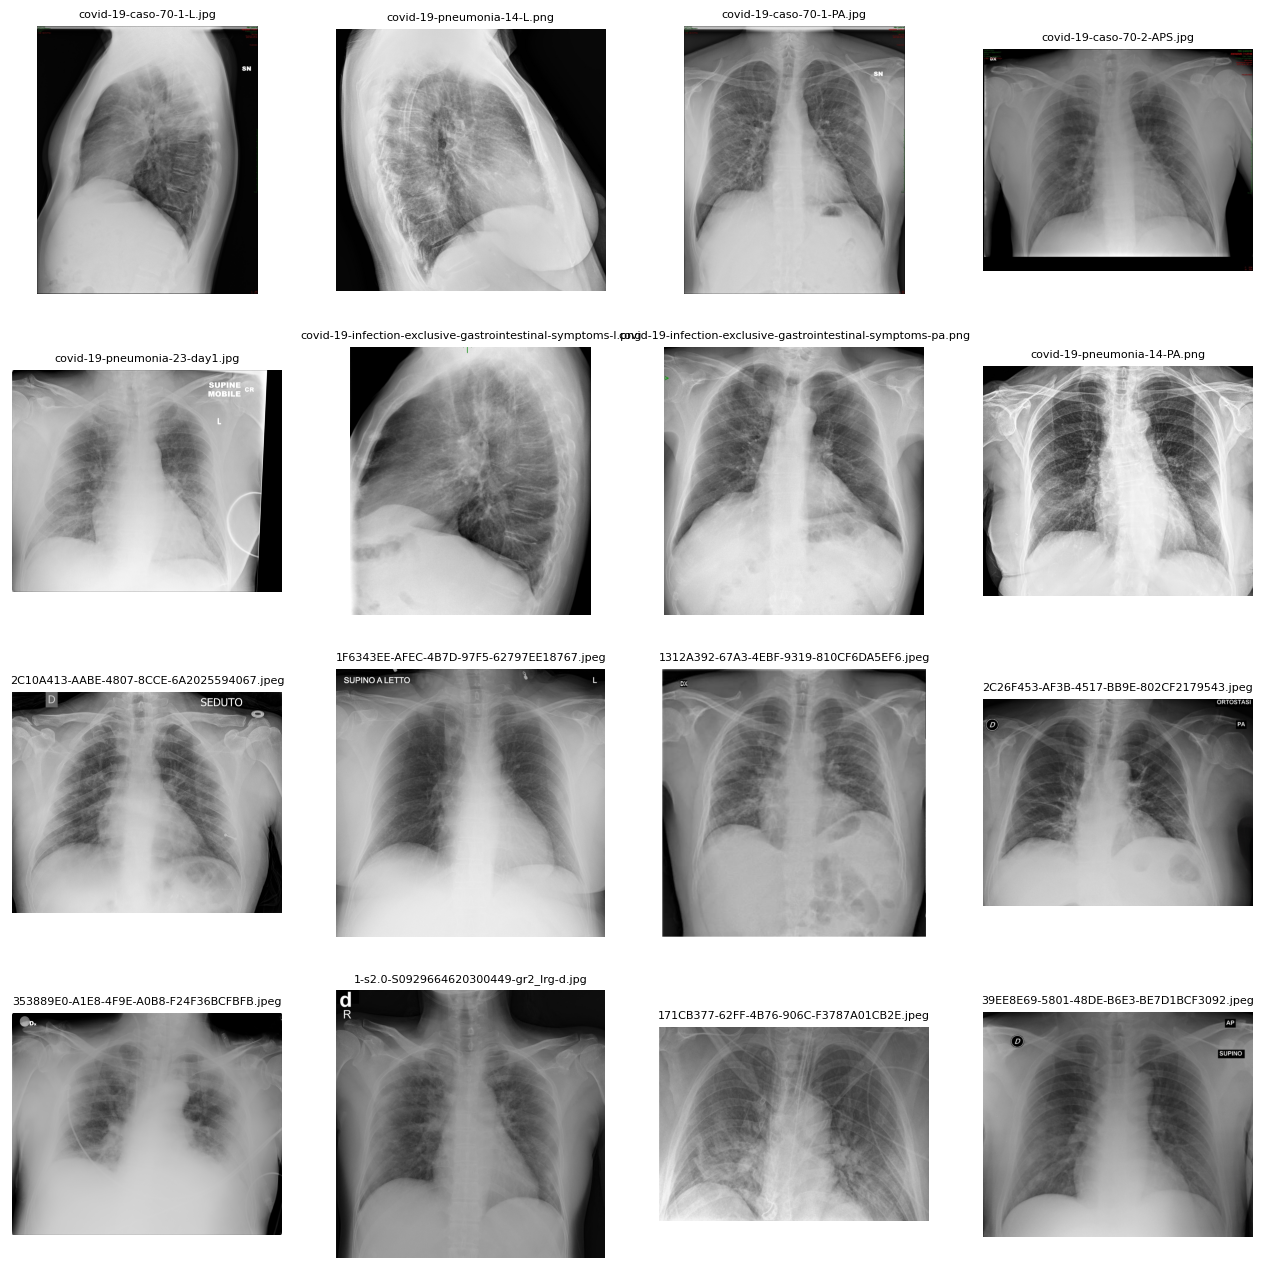

In [22]:
##Image Visualization
L_grid = 4
W_grid = 4

#set the figure size
fig = plt.gcf()
fig.set_size_inches(16,16)

train_img_path = [os.path.join(DATADIR, CATEGORIES[1], img) for img in os.listdir(os.path.join(DATADIR, CATEGORIES[1]))]
test_img_path = [os.path.join(DATADIR, CATEGORIES[0], img) for img in os.listdir(os.path.join(DATADIR, CATEGORIES[0]))]

covid_grid = [img for img in list(train_img_path)[0:8]]
normal_grid = [img for img in list(test_img_path)[0:8]]
for i , img_path in enumerate(covid_grid+normal_grid):
  img_nam=img_path.split('/')[-1]
  axes =plt.subplot(L_grid,W_grid,i+1)
  axes.axis('Off')
  img = mpimg.imread(img_path)
  axes.set_title(img_nam,fontsize=8)
  plt.imshow(img,cmap='gray')
plt.show()

## Image Segmentation

In [23]:
from google.colab import files
uploaded = files.upload()


Saving cxr_reg_weights.best.hdf5 to cxr_reg_weights.best (1).hdf5


In [24]:
dataset = []
IMG_SIZE = 224

def create_training_data():
  for category in tqdm(CATEGORIES):
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    print(class_num)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        dataset.append([new_array, class_num])
      except Exception as e:
        #except OSError as e:
        print("OSErrroBad img most likely", e, os.path.join(path,img))
        #except Exception as e:
        print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(dataset))

  0%|          | 0/2 [00:00<?, ?it/s]

0


 50%|█████     | 1/2 [00:03<00:03,  3.02s/it]

1


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]

156


In [25]:
def create_training_data_with_segmentation(unet_model):
    dataset = []

    for category in tqdm(CATEGORIES):
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)

                # Load grayscale and normalize
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (224, 224))
                img_norm = img / 255.0
                img_input = np.expand_dims(img_norm, axis=(0, -1))  # shape: (1, 224, 224, 1)

                # Predict lung mask
                lung_mask = unet_model.predict(img_input)[0, :, :, 0]  # shape: (224, 224)
                lung_mask = np.expand_dims(lung_mask, axis=-1)  # shape: (224, 224, 1)

                # Load original RGB image
                img_rgb = cv2.imread(img_path)
                img_rgb = cv2.resize(img_rgb, (224, 224))
                img_rgb = img_rgb / 255.0

                # Apply mask to RGB image
                masked_img = img_rgb * lung_mask  # shape: (224, 224, 3)

                dataset.append([masked_img, class_num])

            except Exception as e:
                print(f"Error: {e}, {img_path}")

    return dataset


In [26]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [27]:
model = unet(input_size=(224,224,1))
# Use 'learning_rate' instead of 'lr' when initializing Adam
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 224, 224,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 224, 224,  │      9,248 │ conv2d_22[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 112, 112,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 112, 112,  │     36,928 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 56, 56,    │    147,584 │ conv2d_26[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 28, 28,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 28, 28,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 28, 28,    │    590,080 │ conv2d_28[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 14, 14,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 14, 14,    │  1,180,160 │ max_pooling2d_10… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 14, 14,    │  2,359,808 │ conv2d_30[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 28, 28,    │    524,544 │ conv2d_31[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Gunakan model segmentasi
model.load_weights("/content/cxr_reg_weights.best.hdf5")

# Buat dataset baru
segmented_dataset = create_training_data_with_segmentation(model)

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 1/2 [01:12<01:12, 72.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2/2 [01:54<00:00, 57.44s/it]


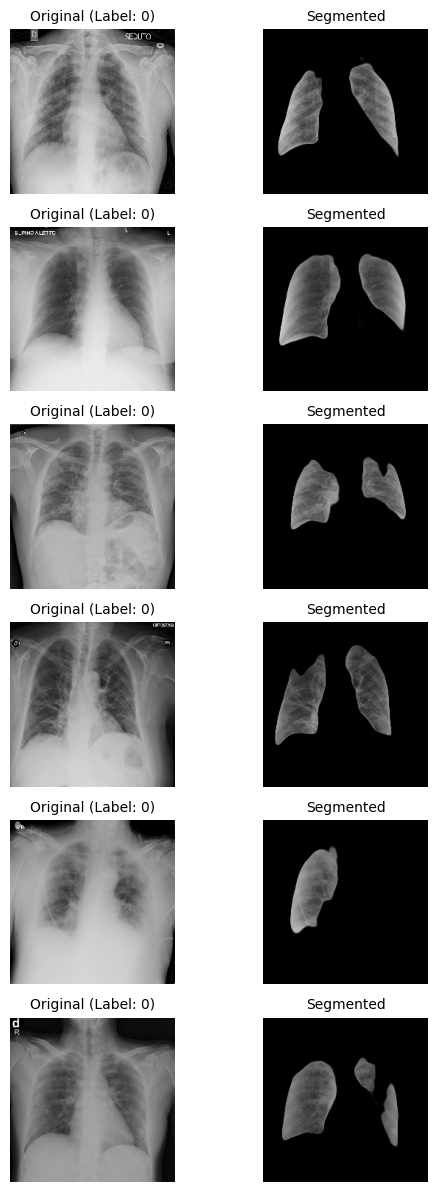

In [29]:
import matplotlib.pyplot as plt

def compare_original_and_segmented_tighter(dataset, segmented_dataset, num_samples=6):
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 2))

    for i in range(num_samples):
        original_img, label = dataset[i]
        segmented_img, _ = segmented_dataset[i]

        # Kiri: Gambar asli
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Label: {label})", fontsize=10)
        axes[i, 0].axis('off')

        # Kanan: Gambar hasil segmentasi
        axes[i, 1].imshow(segmented_img)
        axes[i, 1].set_title("Segmented", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout(pad=1.0)  # atur jarak antar subplot
    plt.show()

# Panggil fungsi
compare_original_and_segmented_tighter(dataset, segmented_dataset, num_samples=6)


# Normalize and Define the Train, Test data

In [30]:
X = []
y = []

for image,label in segmented_dataset:
  features = cv2.resize(image, (224, 224))
  X.append(image)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [31]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [32]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((124, 224, 224, 3), (124,), (32, 224, 224, 3), (32,))

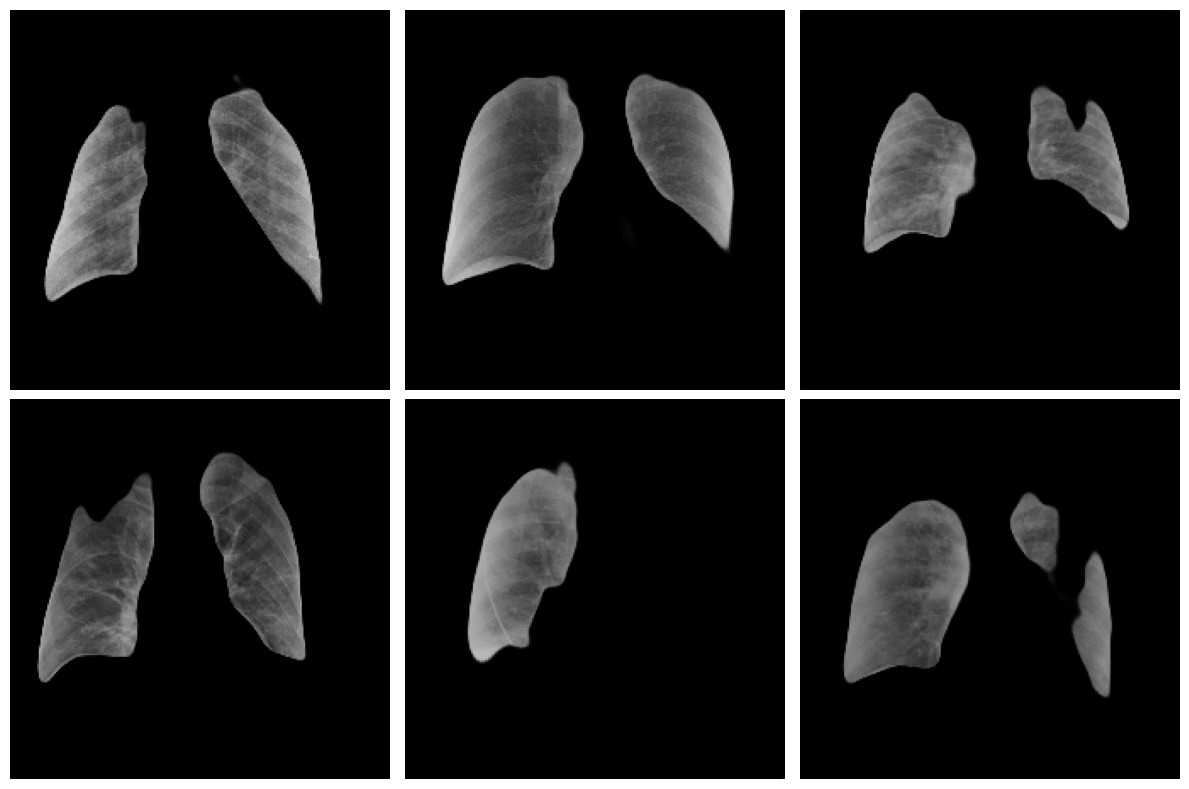

In [33]:
# prompt: tampilkan beberapa gambar di X (tanpa label). X adalah dataset yang akan dijadikan training set sehingga tidak memiliki label

import matplotlib.pyplot as plt
import numpy as np

def show_images(X, num_images=6):
    """Displays a specified number of images from the dataset without labels."""

    num_rows = int(np.ceil(num_images / 3))  # Adjust layout for better display
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

    for i in range(num_images):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(X[i])
        axes[row, col].axis('off')  # Hide axes

    # Hide any empty subplots if num_images isn't a multiple of 3
    for i in range(num_images, num_rows * 3):
        row = i // 3
        col = i % 3
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Assuming 'X' contains your image data as NumPy arrays
show_images(X, num_images=6) # Display the first 6 images


# Modeling and Preprocessing

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Target jumlah data per kelas
target_counts = {
    0: 500,  # kelas negatif
    1: 1000   # kelas positif (penting untuk recall)
}

# Hitung distribusi awal
classes, counts = np.unique(trainY, return_counts=True)
print("Distribusi awal:")
for cls, count in zip(classes, counts):
    print(f"Kelas {cls}: {count} data")

# ImageDataGenerator untuk augmentasi
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = []
augmented_labels = []

# Augmentasi tiap kelas sesuai target_counts
for cls in target_counts:
    current_count = np.sum(trainY == cls)
    target = target_counts[cls]
    needed = target - current_count
    if needed <= 0:
        continue  # Tidak perlu augmentasi

    class_indices = np.where(trainY == cls)[0]
    i = 0
    while needed > 0:
        img = trainX[class_indices[i % len(class_indices)]]
        img = img.reshape((1,) + img.shape)
        label = cls
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            augmented_labels.append(label)
            needed -= 1
            if needed <= 0:
                break
        i += 1

# Gabungkan data asli dan hasil augmentasi
trainX = np.concatenate([trainX, np.array(augmented_images)])
trainY = np.concatenate([trainY, np.array(augmented_labels)])

# Verifikasi distribusi akhir
classes, counts = np.unique(trainY, return_counts=True)
print("\nDistribusi setelah augmentasi:")
for cls, count in zip(classes, counts):
    print(f"Kelas {cls}: {count} data")


Distribusi awal:
Kelas 0: 78 data
Kelas 1: 46 data

Distribusi setelah augmentasi:
Kelas 0: 500 data
Kelas 1: 1000 data


In [35]:
# Some Initialization for Model
input_shape=(trainX.shape[1:])
epochs=10
batch_size=32
num_class=1
print(input_shape)

(224, 224, 3)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN dengan Dropout
def create_model_init(input_shape, num_class):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Dropout ditambahkan di sini
    model.add(Dense(num_class, activation='sigmoid'))

    model.summary()
    return model

# Inisialisasi model
model_init = create_model_init(input_shape, num_class)
model_init.compile(optimizer=RMSprop(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


history_init = model_init.fit(
    x=trainX,
    y=trainY,
    validation_split=0.15,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,873 (98.36 MB)

 Trainable params: 25,783,873 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.7479 - loss: 0.5944 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9699 - loss: 0.0910 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9698 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.9769 - loss: 0.0781 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.9826 - loss: 0.0560 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9879 - loss: 0.0372 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9806 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9922 - loss: 0.0272 - val_accuracy: 1.0000 - v

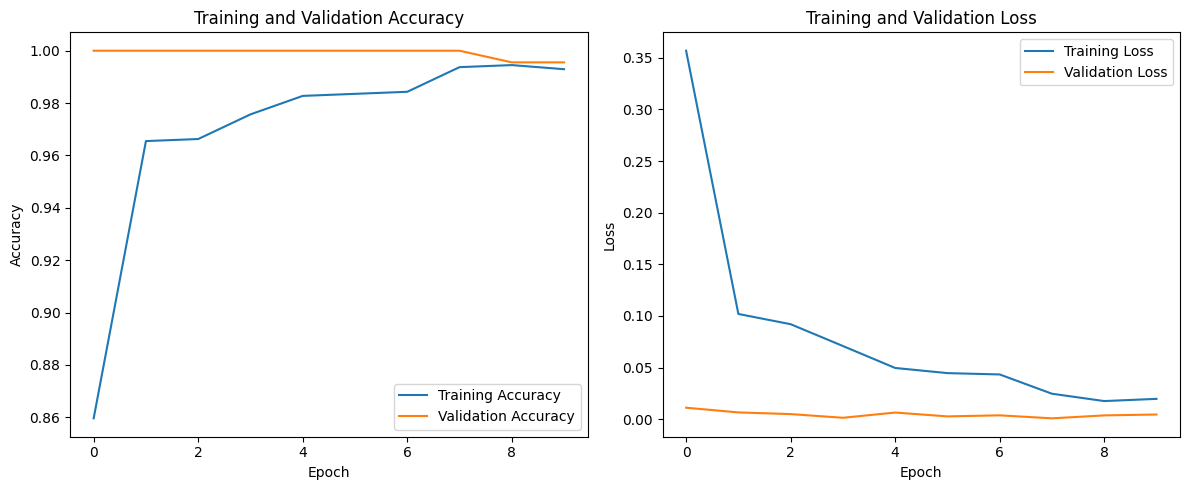

In [38]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_learning_curves(history_init)


In [43]:
import numpy as np

# Prediksi: model mengeluarkan probabilitas, kita ambil argmax jika output one-hot atau >1 kelas
y_pred_probs = model_init.predict(testX)
y_pred = np.argmax(y_pred_probs, axis=1) if y_pred_probs.shape[1] > 1 else (y_pred_probs > 0.5).astype("int").flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63        20
           1       0.36      0.33      0.35        12

    accuracy                           0.53        32
   macro avg       0.49      0.49      0.49        32
weighted avg       0.52      0.53      0.53        32



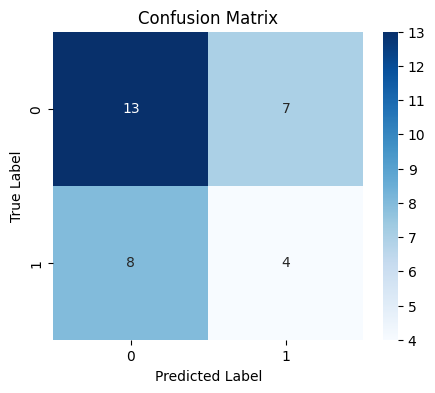

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("Classification Report:")
print(classification_report(testY, y_pred))

# Confusion Matrix
cm = confusion_matrix(testY, y_pred)

# Visualisasi
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
